In [12]:
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [13]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm


In [14]:
from pathlib import Path

DATA_DIR = "C:/Users/manup/Desktop/capstone/code/Dataset"

def get_unique_colors(image_path):
    img = cv2.imread(str(image_path))[:, :, ::-1]  # convert BGR → RGB
    colors = np.unique(img.reshape(-1, 3), axis=0)
    return [tuple(c.tolist()) for c in colors]

# Check one example mask
example_mask = list(Path(DATA_DIR).glob("*_label.png"))[0]
print("Unique colors in sample mask:", get_unique_colors(example_mask))

Unique colors in sample mask: [(0, 0, 0), (127, 127, 127), (255, 255, 255)]


In [15]:
from pathlib import Path

DATA_DIR = Path("C:/Users/manup/Desktop/capstone/code/Dataset")  # e.g., Path("dataset/")

files = sorted([f.name for f in DATA_DIR.iterdir()])
print("Total files:", len(files))
print(files[:20])  # show first 20 filenames


Total files: 720
['Apple_0003.jpg', 'Apple_0003_black.png', 'Apple_0003_label.png', 'Apple_0010.jpg', 'Apple_0010_black.png', 'Apple_0010_label.png', 'Apple_0015.jpg', 'Apple_0015_black.png', 'Apple_0015_label.png', 'Apple_0021.jpg', 'Apple_0021_black.png', 'Apple_0021_label.png', 'Apple_0035.jpg', 'Apple_0035_black.png', 'Apple_0035_label.png', 'Apple_0038.jpg', 'Apple_0038_black.png', 'Apple_0038_label.png', 'Apple_0039.jpg', 'Apple_0039_black.png']


In [16]:
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# --- Directory ---
DATA_DIR = Path("C:/Users/manup/Desktop/capstone/code/Dataset")  # e.g., Path("dataset/")
IMG_SIZE = (256, 256)

# --- Helper functions ---
def load_image(path):
    img = load_img(path, target_size=IMG_SIZE)
    img = img_to_array(img) / 255.0
    return img

def load_mask(path):
    mask = load_img(path, target_size=IMG_SIZE)
    mask = img_to_array(mask)
    label = np.zeros(mask.shape[:2], dtype=np.uint8)
    label[np.all(mask == [0, 0, 0], axis=-1)] = 0       # background
    label[np.all(mask == [127, 127, 127], axis=-1)] = 1 # leaf
    label[np.all(mask == [255, 255, 255], axis=-1)] = 2 # disease
    return label

# --- Collect valid images/masks ---
image_paths = sorted([
    x for x in DATA_DIR.glob("*.jpg")
    if "_black" not in x.name.lower() and "_label" not in x.name.lower()
])

mask_paths = sorted([
    x for x in DATA_DIR.glob("*_label.png")
    if "_black" not in x.name.lower()
])

print(f"Found {len(image_paths)} valid images and {len(mask_paths)} valid masks")

# --- Load dataset ---
X = np.array([load_image(p) for p in image_paths])
Y = np.array([load_mask(p) for p in mask_paths])

# --- Split train/test ---
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

print("Train shapes:", X_train.shape, Y_train.shape)
print("Test shapes:", X_test.shape, Y_test.shape)


Found 240 valid images and 240 valid masks
Train shapes: (216, 256, 256, 3) (216, 256, 256)
Test shapes: (24, 256, 256, 3) (24, 256, 256)


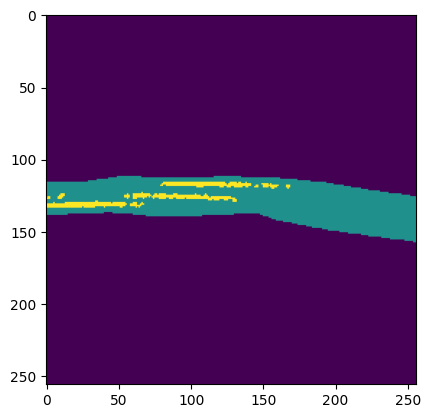

In [17]:
import matplotlib.pyplot as plt
plt.imshow(Y_train[0])  # before one-hot encoding
plt.show()


In [18]:
print(f"Training images shape: {X_train.shape}")
print(f"Training masks shape: {Y_train.shape}")
print("-" * 30)
print(f"Test images shape: {X_test.shape}")
print(f"Test masks shape: {Y_test.shape}")

Training images shape: (216, 256, 256, 3)
Training masks shape: (216, 256, 256)
------------------------------
Test images shape: (24, 256, 256, 3)
Test masks shape: (24, 256, 256)


In [19]:
#enocder block
def encoder_block(input, num_filters):

    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    p = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2)(x)
    
    return x,p

#decoder block
def decoder_block(input, skip_tensor, filters):
    # Upsample
    x = tf.keras.layers.UpSampling2D((2, 2))(input)
    
    # First convolution after upsampling
    x = tf.keras.layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # Concatenate skip connection
    x = tf.keras.layers.concatenate([x, skip_tensor])
    
    # Two consecutive conv layers
    x = tf.keras.layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    return x

def unet(input_shape=(256, 256, 3), num_classes=3):
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # Contracting Path (Encoder)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    
    # Bottleneck
    b1 = tf.keras.layers.Conv2D(1024, 3, padding='same')(p4)
    b1 = tf.keras.layers.BatchNormalization()(b1)
    b1 = tf.keras.layers.Activation('relu')(b1)
    b1 = tf.keras.layers.Conv2D(1024, 3, padding='same')(b1)
    b1 = tf.keras.layers.BatchNormalization()(b1)
    b1 = tf.keras.layers.Activation('relu')(b1)
    
    # Expansive Path (Decoder)
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    
    outputs = tf.keras.layers.Conv2D(num_classes, 1, padding='same', activation='softmax')(d4)
    
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='U-Net')
    return model

In [20]:
import tensorflow as tf
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1, 3])
    y_pred_f = tf.reshape(y_pred, [-1, 3])
    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f, axis=0) + tf.reduce_sum(y_pred_f, axis=0) + smooth)
    return 1 - tf.reduce_mean(dice)

cce_loss_fn = tf.keras.losses.CategoricalCrossentropy()

def combined_loss(y_true, y_pred):
    return cce_loss_fn(y_true, y_pred) + dice_loss(y_true, y_pred)



In [21]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1, NUM_CLASSES])
    y_pred_f = tf.reshape(y_pred, [-1, NUM_CLASSES])
    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f, axis=0) + tf.reduce_sum(y_pred_f, axis=0) + smooth)
    return tf.reduce_mean(dice)


def iou_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1, 3])
    y_pred_f = tf.reshape(y_pred, [-1, 3])
    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    union = tf.reduce_sum(y_true_f, axis=0) + tf.reduce_sum(y_pred_f, axis=0) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return tf.reduce_mean(iou)


In [22]:
import tensorflow as tf

def dice_coef_per_class(y_true, y_pred, class_index, smooth=1e-6):
    y_true_c = y_true[..., class_index]
    y_pred_c = y_pred[..., class_index]
    intersection = tf.reduce_sum(y_true_c * y_pred_c)
    union = tf.reduce_sum(y_true_c) + tf.reduce_sum(y_pred_c)
    return (2. * intersection + smooth) / (union + smooth)

def mean_dice(y_true, y_pred, smooth=1e-6):
    num_classes = tf.shape(y_pred)[-1]
    dices = []
    for c in range(3):  # adjust if dynamic
        dices.append(dice_coef_per_class(y_true, y_pred, c, smooth))
    return tf.reduce_mean(tf.stack(dices))

def dice_loss(y_true, y_pred):
    return 1.0 - mean_dice(y_true, y_pred)

def combined_loss(y_true, y_pred, ce_weight=0.6, dice_weight=0.4, class_weights=None):
    if class_weights is not None:
        weights = tf.constant(class_weights, dtype=tf.float32)
        weights = tf.reshape(weights, [1, 1, 1, -1])
        ce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        ce = tf.reduce_mean(ce * tf.reduce_sum(y_true * weights, axis=-1))
    else:
        ce = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_true, y_pred))
    dl = dice_loss(y_true, y_pred)
    return ce_weight * ce + dice_weight * dl

def make_metric_for_class(i):
    def metric(y_true, y_pred):
        return dice_coef_per_class(y_true, y_pred, i)
    metric.__name__ = f'dice_class_{i}'
    return metric

In [23]:
NUM_CLASSES = 3

# One-hot encode masks
Y_train_cat = tf.keras.utils.to_categorical(Y_train, num_classes=NUM_CLASSES)
Y_test_cat = tf.keras.utils.to_categorical(Y_test, num_classes=NUM_CLASSES)

print("Y_train_cat shape:", Y_train_cat.shape)  # Should be (192, 256, 256, 3)
print("Y_test_cat shape:", Y_test_cat.shape)    # Should be (48, 256, 256, 3)


Y_train_cat shape: (216, 256, 256, 3)
Y_test_cat shape: (24, 256, 256, 3)


In [14]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_unet_model.h5", monitor='val_iou_coef', verbose=1,
    save_best_only=True, mode='max'
)

earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_iou_coef', patience=10, verbose=1, mode='max', restore_best_weights=True
)


In [ ]:

model = unet(input_shape=(256, 256, 3), num_classes=3)
# Compile model
model.compile(
    optimizer='adam',
    loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, ce_weight=0.6, dice_weight=0.4, class_weights=[0.2, 0.3, 2.2]),
    metrics=[make_metric_for_class(0), make_metric_for_class(1), make_metric_for_class(2), mean_dice]
)
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]  

 Total params: 34,540,867 (131.76 MB)

 Trainable params: 34,527,171 (131.71 MB)

 Non-trainable params: 13,696 (53.50 KB)

In [46]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file="unet_architecture.png", show_shapes=True, show_layer_names=True, dpi=100)
print("✅ Architecture diagram saved as 'unet_architecture.png'")

✅ Architecture diagram saved as 'unet_architecture.png'


In [47]:
model_json = model.to_json()
with open("unet.json", "w") as f:
    f.write(model_json)


In [14]:
# model = unet(input_shape=(256, 256, 3), num_classes=3)

# # model.compile(
# #     optimizer=tf.keras.optimizers.Adam(1e-4),
# #     loss=combined_loss,
# #     metrics=['accuracy', dice_coef, iou_coef]
# # )

# class_weights = tf.constant([0.1, 0.35, 0.55], dtype=tf.float32)

# def weighted_cce(y_true, y_pred):
#     # y_true is one-hot encoded
#     cce = tf.keras.losses.CategoricalCrossentropy()
#     # multiply by class weights
#     weights = tf.reduce_sum(class_weights * y_true, axis=-1)
#     return cce(y_true, y_pred) * weights

# # Compile model
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(1e-4),
#     loss=weighted_cce,
#     metrics=[
#         sm.metrics.IOUScore(threshold=0.5),
#         sm.metrics.FScore(threshold=0.5)
#     ]
# )

# model.summary()


In [18]:
BATCH_SIZE = 8
EPOCHS = 30
history = model.fit(
    X_train, Y_train_cat,
    validation_data=(X_test, Y_test_cat),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[checkpoint, earlystop]
)

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - dice_class_0: 0.8767 - dice_class_1: 0.6252 - dice_class_2: 0.3999 - loss: 0.2365 - mean_dice: 0.6339 

c:\Users\manup\Desktop\capstone\code\cap_py\lib\site-packages\keras\src\callbacks\model_checkpoint.py:276: UserWarning: Can save best model only with val_iou_coef available.
  if self._should_save_model(epoch, batch, logs, filepath):


27/27 ━━━━━━━━━━━━━━━━━━━━ 333s 12s/step - dice_class_0: 0.8918 - dice_class_1: 0.6392 - dice_class_2: 0.4314 - loss: 0.2153 - mean_dice: 0.6541 - val_dice_class_0: 0.7035 - val_dice_class_1: 0.1430 - val_dice_class_2: 0.0527 - val_loss: 0.5450 - val_mean_dice: 0.2997
Epoch 2/30


c:\Users\manup\Desktop\capstone\code\cap_py\lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_iou_coef` which is not available. Available metrics are: dice_class_0,dice_class_1,dice_class_2,loss,mean_dice,val_dice_class_0,val_dice_class_1,val_dice_class_2,val_loss,val_mean_dice
  current = self.get_monitor_value(logs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - dice_class_0: 0.9232 - dice_class_1: 0.6917 - dice_class_2: 0.5502 - loss: 0.1849 - mean_dice: 0.7217 

27/27 ━━━━━━━━━━━━━━━━━━━━ 341s 12s/step - dice_class_0: 0.9260 - dice_class_1: 0.6998 - dice_class_2: 0.5622 - loss: 0.1740 - mean_dice: 0.7293 - val_dice_class_0: 0.5286 - val_dice_class_1: 0.4175 - val_dice_class_2: 0.0058 - val_loss: 2.1828 - val_mean_dice: 0.3173
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - dice_class_0: 0.9377 - dice_class_1: 0.7524 - dice_class_2: 0.5796 - loss: 0.1581 - mean_dice: 0.7566 

27/27 ━━━━━━━━━━━━━━━━━━━━ 419s 15s/step - dice_class_0: 0.9371 - dice_class_1: 0.7513 - dice_class_2: 0.6053 - loss: 0.1508 - mean_dice: 0.7646 - val_dice_class_0: 0.0078 - val_dice_class_1: 0.3276 - val_dice_class_2: 5.8980e-04 - val_loss: 39.2474 - val_mean_dice: 0.1120
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_class_0: 0.9508 - dice_class_1: 0.7763 - dice_class_2: 0.6829 - loss: 0.1263 - mean_dice: 0.8034 

27/27 ━━━━━━━━━━━━━━━━━━━━ 361s 13s/step - dice_class_0: 0.9494 - dice_class_1: 0.7851 - dice_class_2: 0.6864 - loss: 0.1263 - mean_dice: 0.8070 - val_dice_class_0: 0.0557 - val_dice_class_1: 0.3353 - val_dice_class_2: 0.0183 - val_loss: 17.0184 - val_mean_dice: 0.1364
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - dice_class_0: 0.9511 - dice_class_1: 0.7718 - dice_class_2: 0.6788 - loss: 0.1287 - mean_dice: 0.8006 

27/27 ━━━━━━━━━━━━━━━━━━━━ 569s 21s/step - dice_class_0: 0.9498 - dice_class_1: 0.7829 - dice_class_2: 0.6676 - loss: 0.1314 - mean_dice: 0.8001 - val_dice_class_0: 0.8072 - val_dice_class_1: 0.3756 - val_dice_class_2: 0.2610 - val_loss: 0.5353 - val_mean_dice: 0.4813
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - dice_class_0: 0.9493 - dice_class_1: 0.7856 - dice_class_2: 0.6673 - loss: 0.1257 - mean_dice: 0.8008 

27/27 ━━━━━━━━━━━━━━━━━━━━ 563s 21s/step - dice_class_0: 0.9555 - dice_class_1: 0.8044 - dice_class_2: 0.6960 - loss: 0.1189 - mean_dice: 0.8186 - val_dice_class_0: 0.5123 - val_dice_class_1: 0.4133 - val_dice_class_2: 0.0030 - val_loss: 2.7363 - val_mean_dice: 0.3095
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - dice_class_0: 0.9581 - dice_class_1: 0.8126 - dice_class_2: 0.7227 - loss: 0.1112 - mean_dice: 0.8312 

27/27 ━━━━━━━━━━━━━━━━━━━━ 564s 21s/step - dice_class_0: 0.9578 - dice_class_1: 0.8113 - dice_class_2: 0.7215 - loss: 0.1112 - mean_dice: 0.8302 - val_dice_class_0: 0.6871 - val_dice_class_1: 0.2810 - val_dice_class_2: 0.2339 - val_loss: 0.8881 - val_mean_dice: 0.4007
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - dice_class_0: 0.9528 - dice_class_1: 0.8073 - dice_class_2: 0.6917 - loss: 0.1200 - mean_dice: 0.8173 

27/27 ━━━━━━━━━━━━━━━━━━━━ 563s 21s/step - dice_class_0: 0.9561 - dice_class_1: 0.8152 - dice_class_2: 0.7141 - loss: 0.1125 - mean_dice: 0.8285 - val_dice_class_0: 0.7673 - val_dice_class_1: 0.4311 - val_dice_class_2: 0.3453 - val_loss: 0.4579 - val_mean_dice: 0.5146
Epoch 9/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - dice_class_0: 0.9540 - dice_class_1: 0.8089 - dice_class_2: 0.6903 - loss: 0.1199 - mean_dice: 0.8178 

27/27 ━━━━━━━━━━━━━━━━━━━━ 562s 21s/step - dice_class_0: 0.9523 - dice_class_1: 0.7956 - dice_class_2: 0.6876 - loss: 0.1235 - mean_dice: 0.8118 - val_dice_class_0: 0.9053 - val_dice_class_1: 0.4958 - val_dice_class_2: 0.0048 - val_loss: 0.8447 - val_mean_dice: 0.4686
Epoch 10/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - dice_class_0: 0.9624 - dice_class_1: 0.8324 - dice_class_2: 0.7231 - loss: 0.1074 - mean_dice: 0.8393 

27/27 ━━━━━━━━━━━━━━━━━━━━ 563s 21s/step - dice_class_0: 0.9623 - dice_class_1: 0.8356 - dice_class_2: 0.7265 - loss: 0.1074 - mean_dice: 0.8415 - val_dice_class_0: 0.8720 - val_dice_class_1: 0.6334 - val_dice_class_2: 0.2712 - val_loss: 0.4231 - val_mean_dice: 0.5922
Epoch 11/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - dice_class_0: 0.9607 - dice_class_1: 0.8169 - dice_class_2: 0.7190 - loss: 0.1053 - mean_dice: 0.8322 

27/27 ━━━━━━━━━━━━━━━━━━━━ 560s 21s/step - dice_class_0: 0.9639 - dice_class_1: 0.8300 - dice_class_2: 0.7371 - loss: 0.1006 - mean_dice: 0.8436 - val_dice_class_0: 0.9144 - val_dice_class_1: 0.5611 - val_dice_class_2: 0.4064 - val_loss: 0.5555 - val_mean_dice: 0.6273
Epoch 12/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - dice_class_0: 0.9645 - dice_class_1: 0.8395 - dice_class_2: 0.7474 - loss: 0.0967 - mean_dice: 0.8505 

27/27 ━━━━━━━━━━━━━━━━━━━━ 564s 21s/step - dice_class_0: 0.9618 - dice_class_1: 0.8328 - dice_class_2: 0.7430 - loss: 0.1014 - mean_dice: 0.8459 - val_dice_class_0: 0.9003 - val_dice_class_1: 0.6032 - val_dice_class_2: 0.5351 - val_loss: 0.2432 - val_mean_dice: 0.6795
Epoch 13/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - dice_class_0: 0.9658 - dice_class_1: 0.8334 - dice_class_2: 0.7463 - loss: 0.0966 - mean_dice: 0.8485 

27/27 ━━━━━━━━━━━━━━━━━━━━ 563s 21s/step - dice_class_0: 0.9669 - dice_class_1: 0.8489 - dice_class_2: 0.7588 - loss: 0.0914 - mean_dice: 0.8582 - val_dice_class_0: 0.9137 - val_dice_class_1: 0.5538 - val_dice_class_2: 0.5327 - val_loss: 0.5140 - val_mean_dice: 0.6667
Epoch 14/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - dice_class_0: 0.9699 - dice_class_1: 0.8586 - dice_class_2: 0.7522 - loss: 0.0910 - mean_dice: 0.8602 

27/27 ━━━━━━━━━━━━━━━━━━━━ 560s 21s/step - dice_class_0: 0.9698 - dice_class_1: 0.8578 - dice_class_2: 0.7474 - loss: 0.0939 - mean_dice: 0.8583 - val_dice_class_0: 0.8697 - val_dice_class_1: 0.6580 - val_dice_class_2: 0.6206 - val_loss: 0.2886 - val_mean_dice: 0.7161
Epoch 15/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - dice_class_0: 0.9686 - dice_class_1: 0.8600 - dice_class_2: 0.7488 - loss: 0.0890 - mean_dice: 0.8592 

27/27 ━━━━━━━━━━━━━━━━━━━━ 560s 21s/step - dice_class_0: 0.9719 - dice_class_1: 0.8696 - dice_class_2: 0.7699 - loss: 0.0833 - mean_dice: 0.8705 - val_dice_class_0: 0.9476 - val_dice_class_1: 0.7640 - val_dice_class_2: 0.6555 - val_loss: 0.2399 - val_mean_dice: 0.7890
Epoch 16/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - dice_class_0: 0.9710 - dice_class_1: 0.8590 - dice_class_2: 0.7753 - loss: 0.0894 - mean_dice: 0.8684 

27/27 ━━━━━━━━━━━━━━━━━━━━ 561s 21s/step - dice_class_0: 0.9683 - dice_class_1: 0.8556 - dice_class_2: 0.7428 - loss: 0.0953 - mean_dice: 0.8555 - val_dice_class_0: 0.9501 - val_dice_class_1: 0.7907 - val_dice_class_2: 0.6747 - val_loss: 0.2248 - val_mean_dice: 0.8052
Epoch 17/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - dice_class_0: 0.9686 - dice_class_1: 0.8552 - dice_class_2: 0.7495 - loss: 0.0964 - mean_dice: 0.8578 

27/27 ━━━━━━━━━━━━━━━━━━━━ 565s 21s/step - dice_class_0: 0.9672 - dice_class_1: 0.8501 - dice_class_2: 0.7457 - loss: 0.0955 - mean_dice: 0.8543 - val_dice_class_0: 0.9276 - val_dice_class_1: 0.6486 - val_dice_class_2: 0.6118 - val_loss: 0.3606 - val_mean_dice: 0.7293
Epoch 18/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - dice_class_0: 0.9737 - dice_class_1: 0.8768 - dice_class_2: 0.7621 - loss: 0.0820 - mean_dice: 0.8709 

27/27 ━━━━━━━━━━━━━━━━━━━━ 424s 13s/step - dice_class_0: 0.9750 - dice_class_1: 0.8764 - dice_class_2: 0.7907 - loss: 0.0789 - mean_dice: 0.8807 - val_dice_class_0: 0.9531 - val_dice_class_1: 0.8294 - val_dice_class_2: 0.7891 - val_loss: 0.1220 - val_mean_dice: 0.8572
Epoch 19/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - dice_class_0: 0.9735 - dice_class_1: 0.8772 - dice_class_2: 0.7631 - loss: 0.0803 - mean_dice: 0.8712 

27/27 ━━━━━━━━━━━━━━━━━━━━ 381s 14s/step - dice_class_0: 0.9753 - dice_class_1: 0.8812 - dice_class_2: 0.7777 - loss: 0.0795 - mean_dice: 0.8781 - val_dice_class_0: 0.9598 - val_dice_class_1: 0.8421 - val_dice_class_2: 0.7448 - val_loss: 0.1296 - val_mean_dice: 0.8489
Epoch 20/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - dice_class_0: 0.9758 - dice_class_1: 0.8821 - dice_class_2: 0.8086 - loss: 0.0735 - mean_dice: 0.8889 

27/27 ━━━━━━━━━━━━━━━━━━━━ 377s 14s/step - dice_class_0: 0.9756 - dice_class_1: 0.8823 - dice_class_2: 0.8079 - loss: 0.0726 - mean_dice: 0.8886 - val_dice_class_0: 0.9643 - val_dice_class_1: 0.8565 - val_dice_class_2: 0.7865 - val_loss: 0.1221 - val_mean_dice: 0.8691
Epoch 21/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - dice_class_0: 0.9815 - dice_class_1: 0.8943 - dice_class_2: 0.7946 - loss: 0.0727 - mean_dice: 0.8902 

27/27 ━━━━━━━━━━━━━━━━━━━━ 323s 12s/step - dice_class_0: 0.9804 - dice_class_1: 0.8979 - dice_class_2: 0.7988 - loss: 0.0711 - mean_dice: 0.8924 - val_dice_class_0: 0.9716 - val_dice_class_1: 0.8747 - val_dice_class_2: 0.8062 - val_loss: 0.1201 - val_mean_dice: 0.8841
Epoch 22/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - dice_class_0: 0.9776 - dice_class_1: 0.8787 - dice_class_2: 0.7915 - loss: 0.0762 - mean_dice: 0.8826 

27/27 ━━━━━━━━━━━━━━━━━━━━ 329s 12s/step - dice_class_0: 0.9770 - dice_class_1: 0.8851 - dice_class_2: 0.8038 - loss: 0.0732 - mean_dice: 0.8886 - val_dice_class_0: 0.9689 - val_dice_class_1: 0.8246 - val_dice_class_2: 0.7364 - val_loss: 0.1191 - val_mean_dice: 0.8433
Epoch 23/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - dice_class_0: 0.9769 - dice_class_1: 0.8948 - dice_class_2: 0.7907 - loss: 0.0717 - mean_dice: 0.8875 

27/27 ━━━━━━━━━━━━━━━━━━━━ 328s 12s/step - dice_class_0: 0.9788 - dice_class_1: 0.8946 - dice_class_2: 0.8010 - loss: 0.0698 - mean_dice: 0.8915 - val_dice_class_0: 0.9707 - val_dice_class_1: 0.8582 - val_dice_class_2: 0.8276 - val_loss: 0.1111 - val_mean_dice: 0.8855
Epoch 24/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - dice_class_0: 0.9794 - dice_class_1: 0.8976 - dice_class_2: 0.8139 - loss: 0.0685 - mean_dice: 0.8970 

27/27 ━━━━━━━━━━━━━━━━━━━━ 488s 18s/step - dice_class_0: 0.9770 - dice_class_1: 0.8852 - dice_class_2: 0.8043 - loss: 0.0733 - mean_dice: 0.8888 - val_dice_class_0: 0.9755 - val_dice_class_1: 0.8925 - val_dice_class_2: 0.8520 - val_loss: 0.0949 - val_mean_dice: 0.9067
Epoch 25/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - dice_class_0: 0.9796 - dice_class_1: 0.8912 - dice_class_2: 0.7999 - loss: 0.0712 - mean_dice: 0.8902 

27/27 ━━━━━━━━━━━━━━━━━━━━ 559s 21s/step - dice_class_0: 0.9801 - dice_class_1: 0.8990 - dice_class_2: 0.8033 - loss: 0.0698 - mean_dice: 0.8941 - val_dice_class_0: 0.9654 - val_dice_class_1: 0.8268 - val_dice_class_2: 0.7953 - val_loss: 0.1137 - val_mean_dice: 0.8625
Epoch 26/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - dice_class_0: 0.9771 - dice_class_1: 0.8908 - dice_class_2: 0.7723 - loss: 0.0761 - mean_dice: 0.8801 

27/27 ━━━━━━━━━━━━━━━━━━━━ 562s 21s/step - dice_class_0: 0.9759 - dice_class_1: 0.8884 - dice_class_2: 0.7788 - loss: 0.0781 - mean_dice: 0.8810 - val_dice_class_0: 0.9677 - val_dice_class_1: 0.8730 - val_dice_class_2: 0.8360 - val_loss: 0.0926 - val_mean_dice: 0.8922
Epoch 27/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - dice_class_0: 0.9769 - dice_class_1: 0.8834 - dice_class_2: 0.8155 - loss: 0.0742 - mean_dice: 0.8919 

27/27 ━━━━━━━━━━━━━━━━━━━━ 561s 21s/step - dice_class_0: 0.9781 - dice_class_1: 0.8915 - dice_class_2: 0.8165 - loss: 0.0702 - mean_dice: 0.8954 - val_dice_class_0: 0.9329 - val_dice_class_1: 0.6388 - val_dice_class_2: 0.7849 - val_loss: 0.2623 - val_mean_dice: 0.7855
Epoch 28/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - dice_class_0: 0.9794 - dice_class_1: 0.8921 - dice_class_2: 0.8251 - loss: 0.0662 - mean_dice: 0.8989 

27/27 ━━━━━━━━━━━━━━━━━━━━ 562s 21s/step - dice_class_0: 0.9786 - dice_class_1: 0.8915 - dice_class_2: 0.8202 - loss: 0.0673 - mean_dice: 0.8968 - val_dice_class_0: 0.9684 - val_dice_class_1: 0.8537 - val_dice_class_2: 0.8477 - val_loss: 0.1173 - val_mean_dice: 0.8899
Epoch 29/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - dice_class_0: 0.9791 - dice_class_1: 0.9050 - dice_class_2: 0.8288 - loss: 0.0636 - mean_dice: 0.9043 

27/27 ━━━━━━━━━━━━━━━━━━━━ 561s 21s/step - dice_class_0: 0.9819 - dice_class_1: 0.9071 - dice_class_2: 0.8279 - loss: 0.0628 - mean_dice: 0.9056 - val_dice_class_0: 0.9730 - val_dice_class_1: 0.8288 - val_dice_class_2: 0.7145 - val_loss: 0.1201 - val_mean_dice: 0.8388
Epoch 30/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - dice_class_0: 0.9833 - dice_class_1: 0.9036 - dice_class_2: 0.7939 - loss: 0.0653 - mean_dice: 0.8936 

27/27 ━━━━━━━━━━━━━━━━━━━━ 326s 12s/step - dice_class_0: 0.9815 - dice_class_1: 0.9041 - dice_class_2: 0.8139 - loss: 0.0665 - mean_dice: 0.8999 - val_dice_class_0: 0.9759 - val_dice_class_1: 0.8981 - val_dice_class_2: 0.8666 - val_loss: 0.0809 - val_mean_dice: 0.9135


In [19]:
import pickle
with open("training_history.pkl", "wb") as f:
    pickle.dump(history.history, f)


In [20]:
model.save_weights("unet.weights.h5")


In [21]:
model.save("best_unet_model.keras")  # or "best_unet_model.h5"


c:\Users\manup\Desktop\capstone\code\cap_py\lib\site-packages\keras\src\saving\serialization_lib.py:405: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:     loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, ce_weight=0.6, dice_weight=0.4, class_weights=[0.2, 0.3, 2.2]),

  return {key: serialize_keras_object(value) for key, value in obj.items()}


In [22]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open("unet_model_quantized.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\manup\AppData\Local\Temp\tmphxwa3xh9\assets


INFO:tensorflow:Assets written to: C:\Users\manup\AppData\Local\Temp\tmphxwa3xh9\assets


Saved artifact at 'C:\Users\manup\AppData\Local\Temp\tmphxwa3xh9'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_80')
Output Type:
  TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)
Captures:
  2199440281088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2199552062768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2199552149632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2199552152976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2199552150160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2199552151744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2199552158784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2199552156848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2199552155616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2199552161424: TensorSpec(shape=(), dtype=tf.resource, name=

In [25]:
from tensorflow.keras.models import load_model

model = load_model(
    "segmentation_model/best_unet1/best_unet_model1.h5",
    custom_objects={
        'combined_loss': combined_loss,
        'dice_coef': dice_coef,
        'iou_coef': iou_coef
    },
    compile=False  # <-- outside of custom_objects
)


In [26]:
pred_masks = model.predict(X_test[:5])  # (batch, 256, 256, n_classes)
print("Predicted mask min/max per channel:")
for i in range(pred_masks.shape[-1]):
    print(f"Channel {i}: min={pred_masks[:,:,:,i].min()}, max={pred_masks[:,:,:,i].max()}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted mask min/max per channel:
Channel 0: min=8.393677752849271e-09, max=0.999998927116394
Channel 1: min=8.484908886607911e-10, max=0.9999998807907104
Channel 2: min=4.670983738686019e-11, max=1.0


In [27]:
print("Shape of Y_test_cat:", Y_test_cat.shape)   # (batch, 256, 256, n_classes)
print("Unique values in test masks (after argmax):", np.unique(np.argmax(Y_test_cat[:5], axis=-1)))


Shape of Y_test_cat: (24, 256, 256, 3)
Unique values in test masks (after argmax): [0 1 2]


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


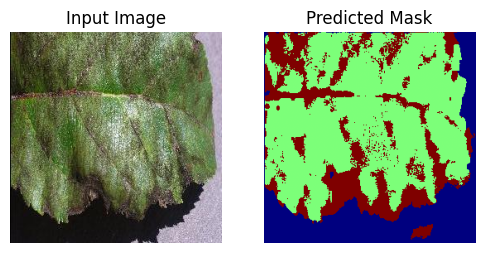

In [42]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

IMG_SIZE = (256, 256)

def preprocess_image(img_path):
    img = load_img(img_path, target_size=IMG_SIZE)
    img = img_to_array(img) / 255.0       # normalize
    img = np.expand_dims(img, axis=0)     # add batch dimension
    return img

# Example
test_image_path = "C:/Users/manup/Desktop/capstone/code/crop_dataset/test/test/AppleScab3.JPG"
img = preprocess_image(test_image_path)

pred_mask = model.predict(img)  # shape: (1, 256, 256, 3)
pred_mask_class = np.argmax(pred_mask, axis=-1)  # convert softmax to class labels
pred_mask_class = pred_mask_class[0]  # remove batch dimension

plt.figure(figsize=(6, 4))

plt.subplot(1, 2, 1)
plt.imshow(img[0])  # assuming img is normalized or in [0,255]
plt.title("Input Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(pred_mask_class, cmap='jet')
plt.title("Predicted Mask")
plt.axis('off')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


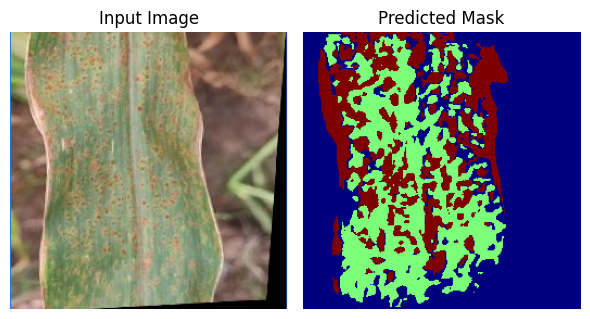

In [32]:

# --- Path to your image ---
img_path = "C:/Users/manup/OneDrive/Pictures/Screenshots 1/Screenshot 2025-10-25 215833.png"

# --- Load and preprocess the image ---
img = load_img(img_path, target_size=(256, 256))   # same size used in training
img_array = img_to_array(img) / 255.0              # normalize like training data
img_input = np.expand_dims(img_array, axis=0)      # add batch dimension → (1, 256, 256, 3)

# --- Predict ---
pred_mask = model.predict(img_input)               # shape (1, 256, 256, n_classes)
pred_mask = np.argmax(pred_mask[0], axis=-1)       # remove batch dim → (256, 256)

# --- If you have ground truth mask for this image (optional) ---
# gt_mask = load_img("path_to_mask.png", target_size=(256, 256), color_mode="grayscale")
# gt_mask = np.array(gt_mask)

# --- Plot Input and Prediction ---
fig, axes = plt.subplots(1, 2, figsize=(6, 4))

axes[0].imshow(img_array)
axes[0].set_title("Input Image")
axes[0].axis('off')

axes[1].imshow(pred_mask, cmap='jet', vmin=0, vmax=2)
axes[1].set_title("Predicted Mask")
axes[1].axis('off')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


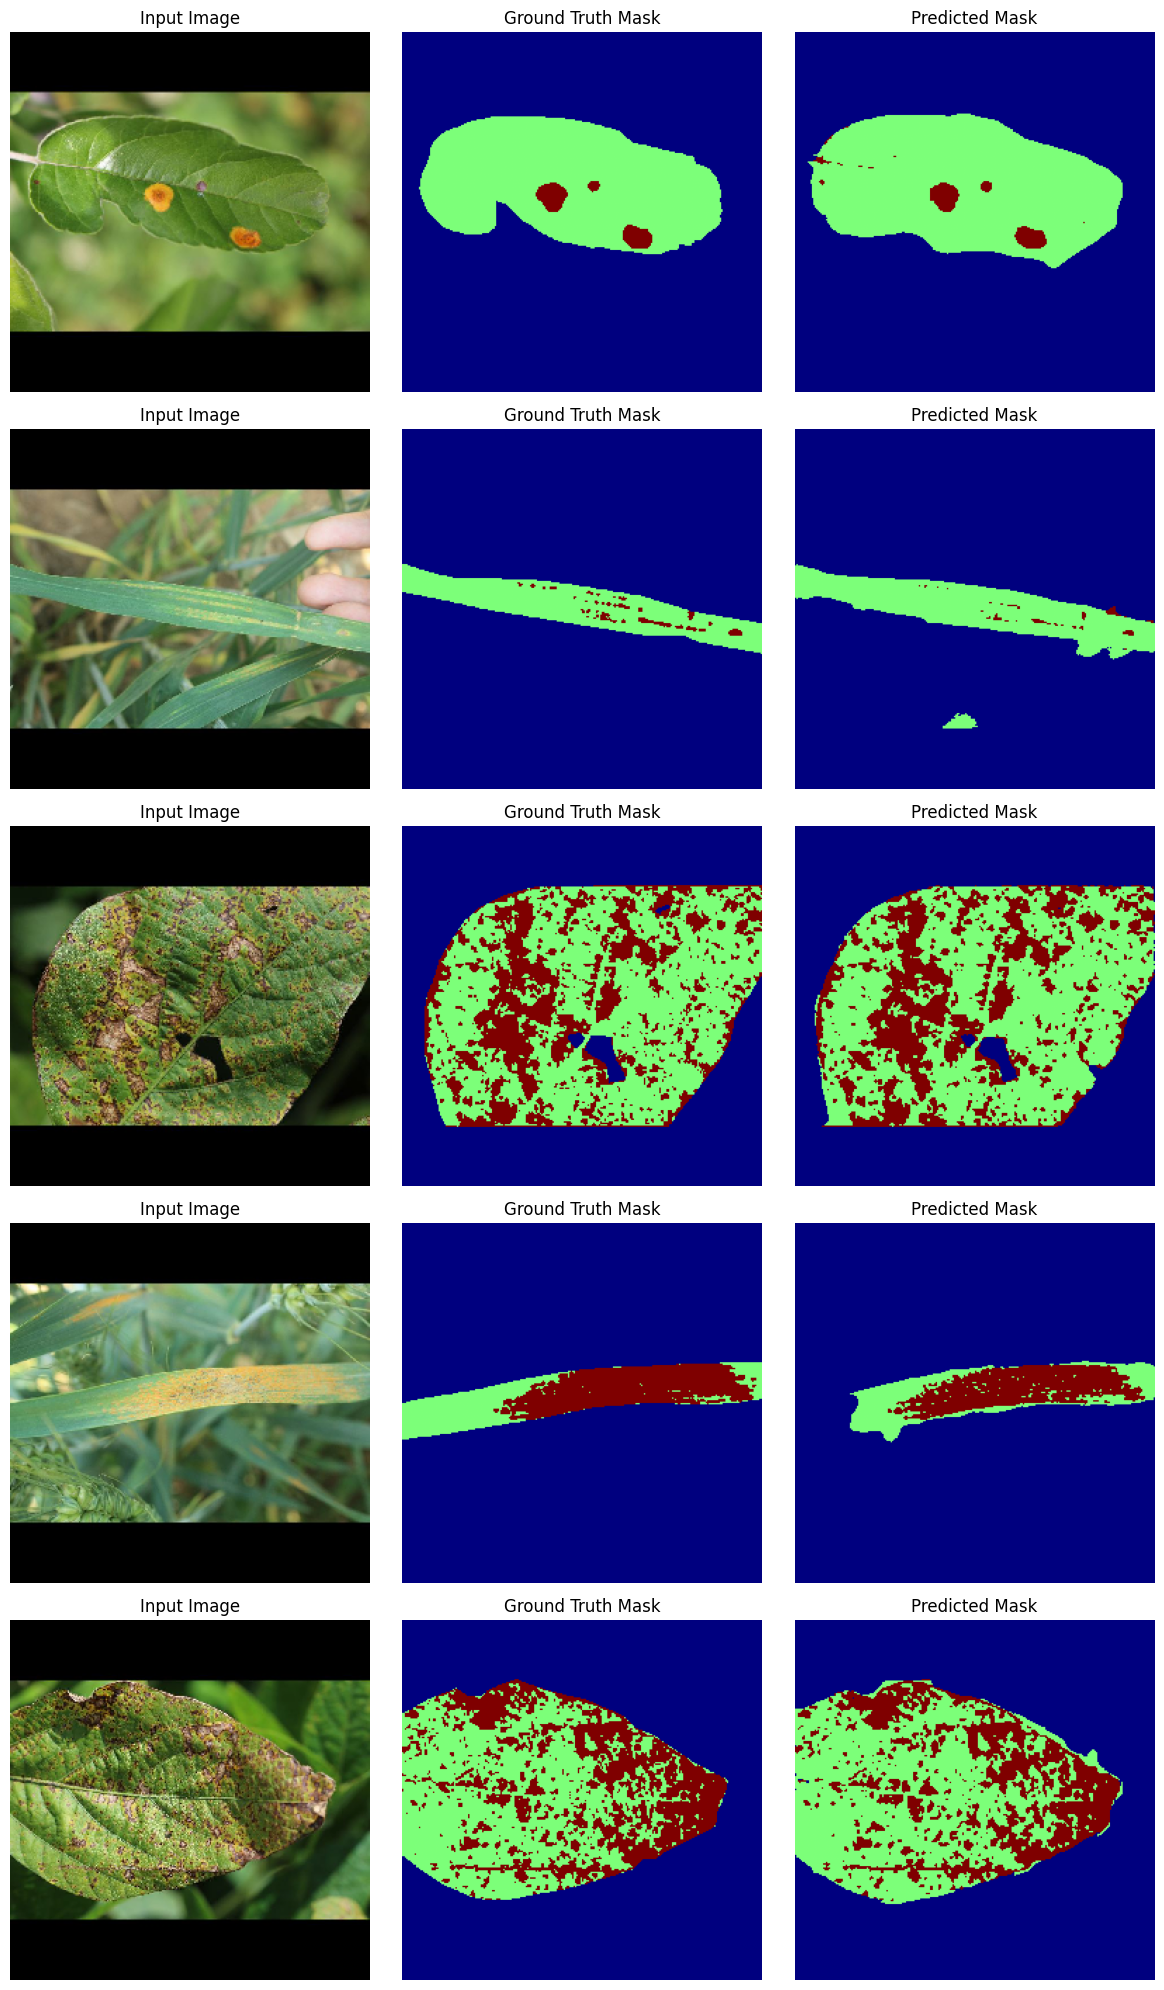

In [30]:
test_images = X_test[10:15]        # preprocessed normalized images
test_masks_cat = Y_test_cat[10:15] 

test_masks = np.argmax(test_masks_cat, axis=-1)  # shape: (batch, 256, 256)

# --- Predict masks ---
pred_masks = model.predict(test_images)          # shape: (batch, 256, 256, n_classes)
pred_masks = np.argmax(pred_masks, axis=-1)     # convert to class indices

# --- Plot input, ground truth, prediction ---
fig, axes = plt.subplots(len(test_images), 3, figsize=(12, len(test_images)*4))

for i in range(len(test_images)):
    axes[i,0].imshow(test_images[i])
    axes[i,0].set_title("Input Image")
    axes[i,0].axis('off')
    
    axes[i,1].imshow(test_masks[i], cmap='jet', vmin=0, vmax=2)
    axes[i,1].set_title("Ground Truth Mask")
    axes[i,1].axis('off')
    
    axes[i,2].imshow(pred_masks[i], cmap='jet', vmin=0, vmax=2)
    axes[i,2].set_title("Predicted Mask")
    axes[i,2].axis('off')

plt.tight_layout()
plt.show(

)

Available metrics: dict_keys(['dice_class_0', 'dice_class_1', 'dice_class_2', 'loss', 'mean_dice', 'val_dice_class_0', 'val_dice_class_1', 'val_dice_class_2', 'val_loss', 'val_mean_dice'])


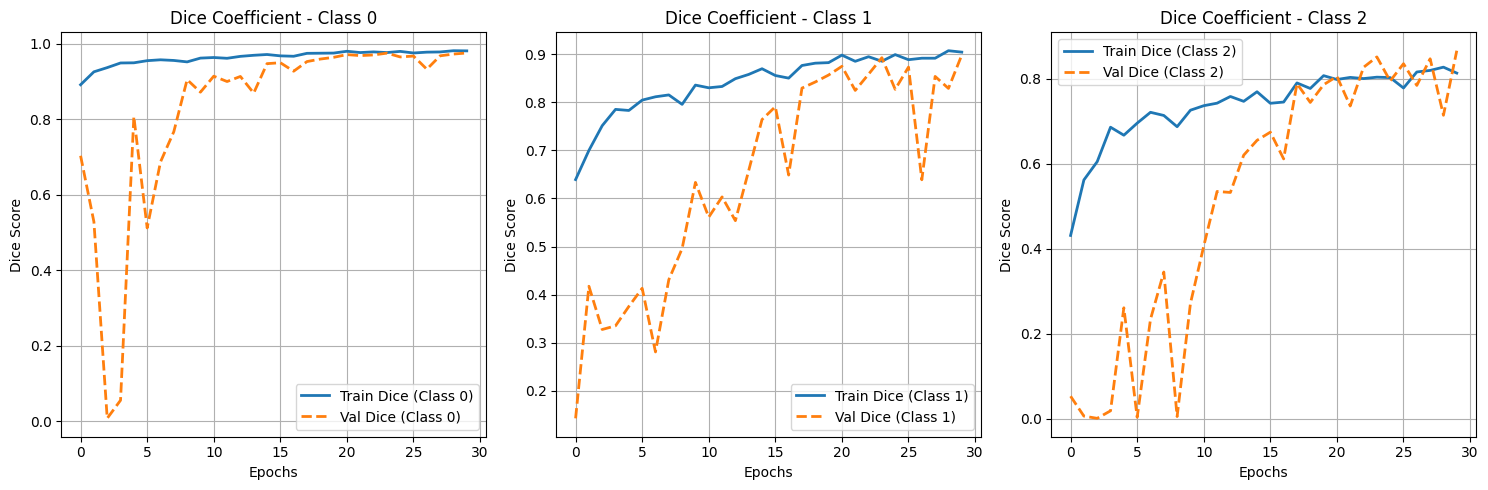

In [62]:
import matplotlib.pyplot as plt

# ✅ Check available metric keys first
print("Available metrics:", history.history.keys())

# --- Create figure with 3 subplots (for 3 classes) ---
plt.figure(figsize=(15, 5))

# --- Class 0 ---
plt.subplot(1, 3, 1)
plt.plot(history.history['dice_class_0'], label='Train Dice (Class 0)', linewidth=2)
plt.plot(history.history['val_dice_class_0'], '--', label='Val Dice (Class 0)', linewidth=2)
plt.title('Dice Coefficient - Class 0')
plt.xlabel('Epochs')
plt.ylabel('Dice Score')
plt.legend()
plt.grid(True)

# --- Class 1 ---
plt.subplot(1, 3, 2)
plt.plot(history.history['dice_class_1'], label='Train Dice (Class 1)', linewidth=2)
plt.plot(history.history['val_dice_class_1'], '--', label='Val Dice (Class 1)', linewidth=2)
plt.title('Dice Coefficient - Class 1')
plt.xlabel('Epochs')
plt.ylabel('Dice Score')
plt.legend()
plt.grid(True)

# --- Class 2 ---
plt.subplot(1, 3, 3)
plt.plot(history.history['dice_class_2'], label='Train Dice (Class 2)', linewidth=2)
plt.plot(history.history['val_dice_class_2'], '--', label='Val Dice (Class 2)', linewidth=2)
plt.title('Dice Coefficient - Class 2')
plt.xlabel('Epochs')
plt.ylabel('Dice Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


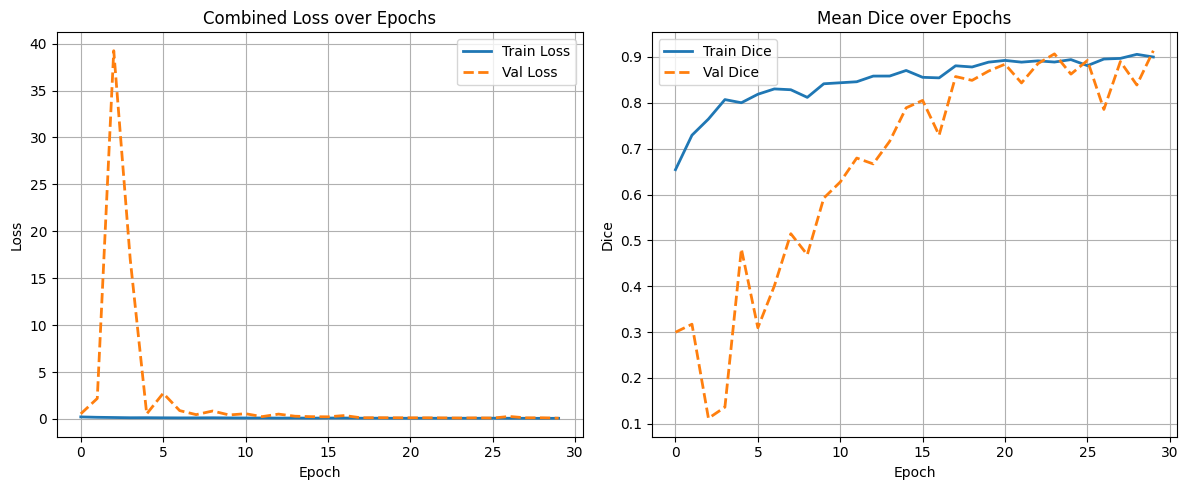

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# --- Loss ---
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], '--', label='Val Loss', linewidth=2)
plt.title('Combined Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# --- Mean Dice ---
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_dice'], label='Train Dice', linewidth=2)
plt.plot(history.history['val_mean_dice'], '--', label='Val Dice', linewidth=2)
plt.title('Mean Dice over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


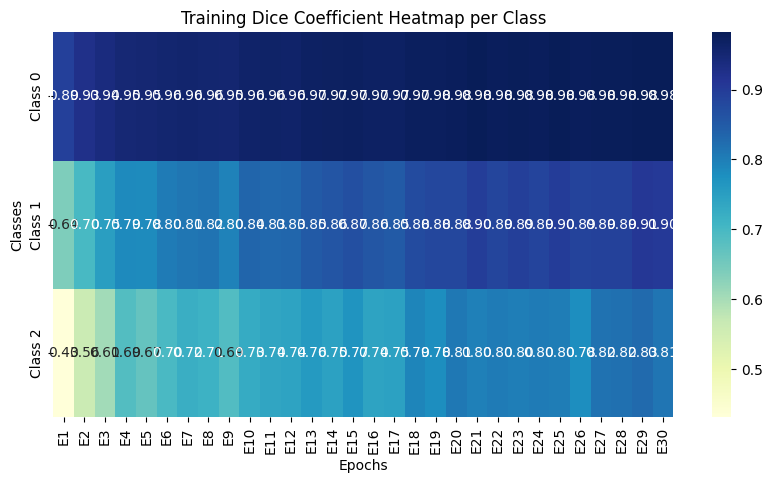

In [77]:
import numpy as np
import seaborn as sns

classes = ['Class 0', 'Class 1', 'Class 2']
train_dice = np.array([
    history.history['dice_class_0'],
    history.history['dice_class_1'],
    history.history['dice_class_2']
])
val_dice = np.array([
    history.history['val_dice_class_0'],
    history.history['val_dice_class_1'],
    history.history['val_dice_class_2']
])

plt.figure(figsize=(10, 5))
sns.heatmap(train_dice, annot=True, fmt=".2f", cmap="YlGnBu",
            xticklabels=[f'E{i+1}' for i in range(len(train_dice[0]))],
            yticklabels=classes)
plt.title('Training Dice Coefficient Heatmap per Class')
plt.xlabel('Epochs')
plt.ylabel('Classes')
plt.show()


In [ ]:
# !{sys.executable} -m pip install seaborn


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
   ---------------------------------------- 0.0/11.3 MB ? eta -:--:--
    --------------------------------------- 0.3/11.3 MB ? eta -:--:--
   -------- ------------------------------- 2.4/11.3 MB 8.4 MB/s eta 0:00:02
   ----------------- ---------------------- 5.0/11.3 MB 10.4 MB/s eta 0:00:01
   ------------------------- -------------- 7.3/11.3 MB 10.5 MB/s eta 0:00:01
   ---------------------------------------  11.3/11.3 MB 12.4 MB/s eta 0:00:01
   ---------------------------------------- 11.3/11.3 MB 12.0 MB/s  0:00:01

   ---------------------------------------- 0/4 [pytz]
   ---------------------------------------- 0/4 [pytz]
   ---------------------------------------- 0/4 [pytz]
   ---------------------------------------- 0/4 [pytz]
   ---------- ----------------------------- 1/4 [tzdata]
   ---------- ----------------------------- 1/4 [tzdata]
   ---------- ----

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step


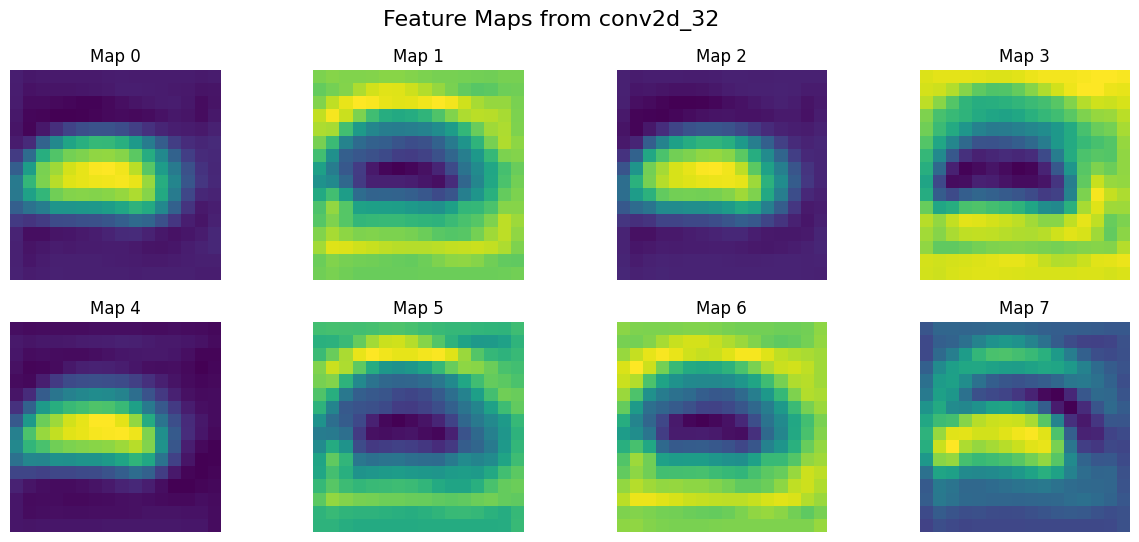

In [74]:
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

sample = X_test[0][np.newaxis, ...]  # single image

layer_name = 'conv2d_32'  # bottleneck layer
intermediate_model = Model(inputs=model.input,
                           outputs=model.get_layer(layer_name).output)

feature_maps = intermediate_model.predict(sample)

# Show first 8 feature maps
plt.figure(figsize=(15, 6))
for i in range(min(8, feature_maps.shape[-1])):
    plt.subplot(2, 4, i + 1)
    plt.imshow(feature_maps[0, :, :, i], cmap='viridis')
    plt.axis('off')
    plt.title(f'Map {i}')
plt.suptitle(f'Feature Maps from {layer_name}', fontsize=16)
plt.show()


In [71]:
for i, layer in enumerate(model.layers):
    # Use getattr to safely get output_shape, fallback to 'N/A' if not available
    shape = getattr(layer, 'output_shape', 'N/A')
    print(i, layer.name, shape)


0 input_layer_1 N/A
1 conv2d_23 N/A
2 batch_normalization_22 N/A
3 activation_22 N/A
4 conv2d_24 N/A
5 batch_normalization_23 N/A
6 activation_23 N/A
7 max_pooling2d_4 N/A
8 conv2d_25 N/A
9 batch_normalization_24 N/A
10 activation_24 N/A
11 conv2d_26 N/A
12 batch_normalization_25 N/A
13 activation_25 N/A
14 max_pooling2d_5 N/A
15 conv2d_27 N/A
16 batch_normalization_26 N/A
17 activation_26 N/A
18 conv2d_28 N/A
19 batch_normalization_27 N/A
20 activation_27 N/A
21 max_pooling2d_6 N/A
22 conv2d_29 N/A
23 batch_normalization_28 N/A
24 activation_28 N/A
25 conv2d_30 N/A
26 batch_normalization_29 N/A
27 activation_29 N/A
28 max_pooling2d_7 N/A
29 conv2d_31 N/A
30 batch_normalization_30 N/A
31 activation_30 N/A
32 conv2d_32 N/A
33 batch_normalization_31 N/A
34 activation_31 N/A
35 up_sampling2d_4 N/A
36 conv2d_33 N/A
37 batch_normalization_32 N/A
38 activation_32 N/A
39 concatenate_4 N/A
40 conv2d_34 N/A
41 batch_normalization_33 N/A
42 activation_33 N/A
43 conv2d_35 N/A
44 batch_normalizati

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


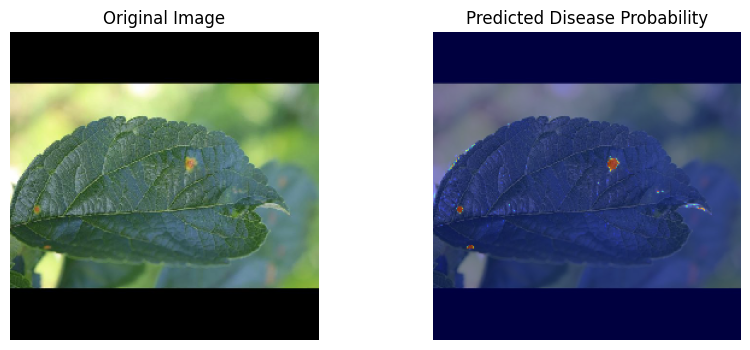

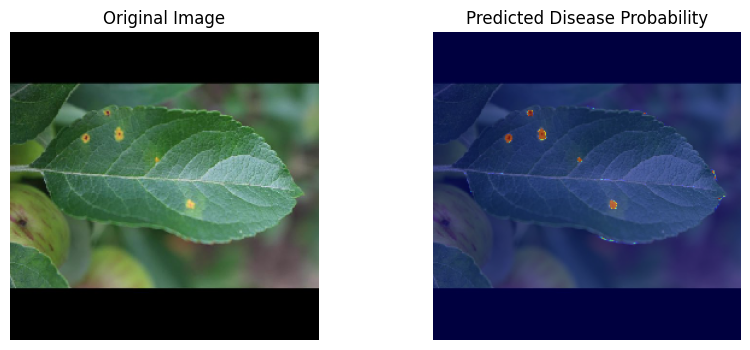

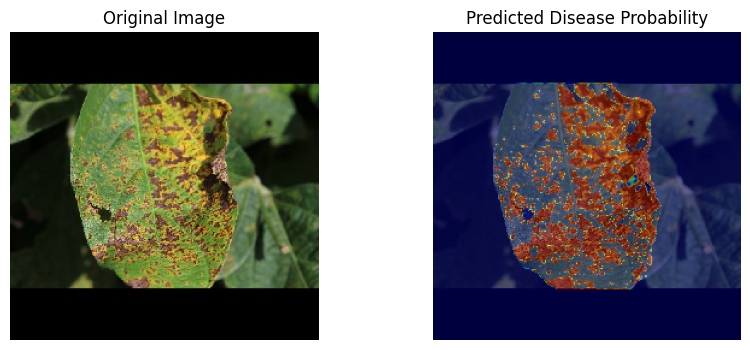

In [ ]:
# Predict softmax probabilities
pred_probs = model.predict(X_test[:3])

for i in range(3):
    image = X_test[i]
    prob_map = pred_probs[i, :, :, 2]  # assuming class 2 = disease

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.imshow(prob_map, cmap='jet', alpha=0.5)
    plt.title('Predicted Disease Probability')
    plt.axis('off')
    plt.show() 


In [50]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

IMG_SIZE = (256, 256)

def preprocess_image(img_path):
    img = load_img(img_path, target_size=IMG_SIZE)
    img = img_to_array(img) / 255.0       # normalize
    img = np.expand_dims(img, axis=0)     # add batch dimension
    return img

def compute_severity(pred_idx, background_class=0, leaf_class=1, disease_class=2):
    # pred_idx: HxW integer class predictions
    leaf_pixels = np.sum(pred_idx == leaf_class)
    disease_pixels = np.sum(pred_idx == disease_class)
    if leaf_pixels == 0:
        return None  # or 0.0, but careful — no leaf detected
    severity = disease_pixels / (leaf_pixels + disease_pixels)
    return severity


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step


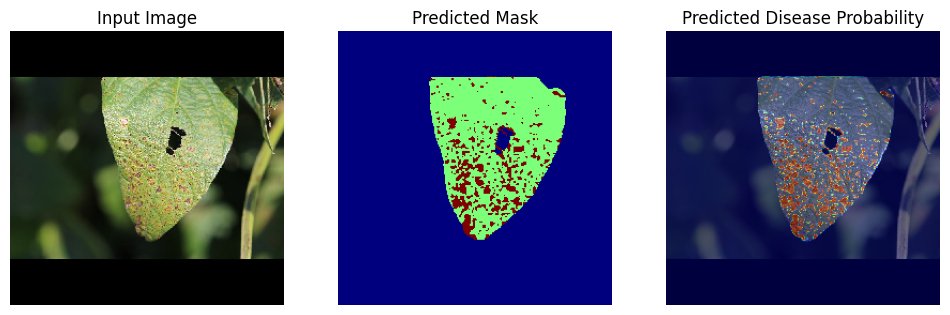

Severity (disease / leaf): 18.65%


In [66]:
test_image_path = "C:/Users/manup/Desktop/capstone/code/Dataset/Soybean_0166.jpg"

img1 = load_img(test_image_path, target_size=IMG_SIZE)
img1 = img_to_array(img1) / 255.0 
img = preprocess_image(test_image_path)

pred_mask = model.predict(img)  # (1, 256, 256, 3)
pred_mask_class = np.argmax(pred_mask, axis=-1)[0]  # (256, 256)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img[0])
plt.title("Input Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(pred_mask_class, cmap='jet')
plt.title("Predicted Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img1)
plt.imshow(pred_mask[0, :, :, 2], cmap='jet', alpha=0.5)
plt.title("Predicted Disease Probability")
plt.axis('off')

plt.show()

severity = compute_severity(pred_mask_class)
print(f"Severity (disease / leaf): {severity * 100:.2f}%")
